In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

from matplotlib.pyplot import figure
from astropy.io import fits
from astropy.table import Table

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import QTable

filename_path = 'data/astraMWMLite-0.6.0.fits'

# this function is Lucy's way to get rid of columns that are more than 1D (pandas doesn't support that)
def Table_to_pandas(fn):
    data = fits.open(fn)
    df = QTable(data[1].data)
    cols = []
    cols_drop = []
    for i in df.columns:
        if np.size(df[i][0])==1:
            cols.append(i)
        else:
            cols_drop.append(i)
    print(cols_drop)
    return df[cols].to_pandas()

df_sdss5 = Table_to_pandas(filename_path)

df_sdss5 = df_sdss5[(df_sdss5['teff']>4500) & (df_sdss5['teff']<6500)]
df_sdss5 = df_sdss5[(df_sdss5['snr']>=200)]

['sdss5_target_flags']


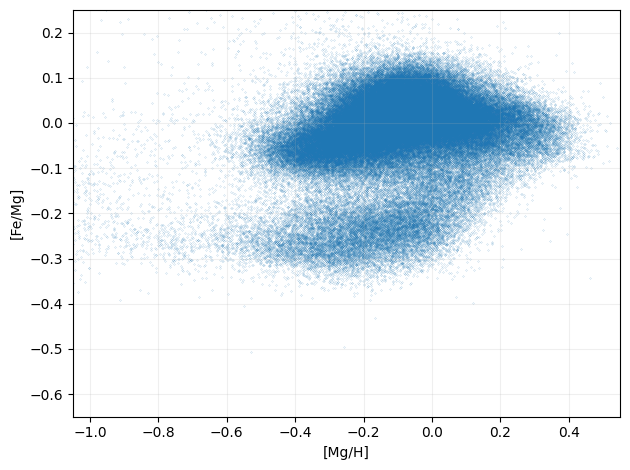

In [5]:
# Just taking a look

df_sdss5['fe_mg'] = df_sdss5['fe_h'] - df_sdss5['mg_h']

plt.scatter(df_sdss5['mg_h'], df_sdss5['fe_mg'], s = 0.01)
plt.grid('True', alpha = 0.2)
plt.xlabel('[Mg/H]')
plt.ylabel('[Fe/Mg]')
plt.ylim(-0.65,0.25)
plt.xlim(-1.05,0.55)
plt.tight_layout()

In [6]:
#Cut on Fe/H
df_sdss_metcut = df_sdss5
df_sdss_metcut = df_sdss_metcut.loc[df_sdss_metcut['e_fe_h']<0.1].reset_index(drop=True)

In [7]:
#Complete filtered SDSS data "df_sdss_metcut"

df_sdss_metcut['gaia_dr3_source_id'].to_csv('data/gaia_ids_from_sdss.txt', index=False, header=False)

# How many of stars cross-matched between SDSS and GAIA have RVS and good SNR?

In [13]:
df_gaia_rvs_flags = pd.read_csv("data/gaia_rvs_flags.csv")
df_gaia_rvs_flags.head()

,source_id,rvs_spec_sig_to_noise,has_rvs
0,1628119301873489664,NaN,False
1,2782313903504860032,NaN,False
2,6049174399459153024,NaN,False
3,2768951126376003712,NaN,False
4,530736053734139008,NaN,False


In [ ]:
# High SNR Gaia spectra
df_gaia_has_rvs = df_gaia_rvs_flags[df_gaia_rvs_flags['has_rvs'] == True]
df_gaia_high_snr = df_gaia_has_rvs[df_gaia_has_rvs['rvs_spec_sig_to_noise'] > 100]

#df_gaia_high_snr['source_id'].to_csv("data/gaia_high_snr_source_ids.csv", index=False)

In [16]:
# Save high SNR ones to a vot table
from astropy.table import Table

# Create an Astropy table from the source_id column
t = Table()
t['source_id'] = df_gaia_high_snr['source_id'].values

# Write to VOTable
t.write('data/gaia_high_snr_source_ids.vot', format='votable', overwrite=True)

Then we upload the "gaia_rvs_list.vot" into https://gaia.aip.de/

Then we download the spectra from gaia aip. And rvs_1 is the downloaded spectra.

https://gaia.aip.de/metadata/gaiadr3/rvs_mean_spectrum/

"This is the RVS mean sampled spectrum table. The spectra are in the rest frame, they are normalised and their wavelength grid ranges from 846 to 870 nm in steps of 0.01 nm (2401 elements)."

Text(0, 0.5, 'Flux')

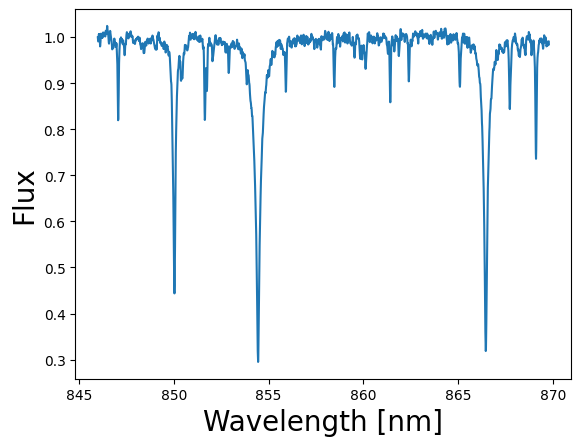

In [19]:
lambdas = np.linspace(846, 870, 2401)

t = Table.read("data/rvs_1.xml", format="votable")

rvs_1_df = t.to_pandas()

eg = rvs_1_df.iloc[0]

plt.plot(lambdas, eg['flux'])
plt.xlabel('Wavelength [nm]', fontsize=20)
plt.ylabel('Flux', fontsize=20)

In [ ]:
print("len df_sdss5 (no met cut) = ", len(df_sdss5))
print("len df_sdss_metcut = ", len(df_sdss_metcut))
print("len df_gaia_high_snr = ", len(df_gaia_high_snr))
print("len rvs_1 = ", len(rvs_1_df))

len df_sdss5 (no met cut) =  154469
len df_sdss_metcut =  152671
len df_gaia_high_snr =  11067
len rvs_1 =  11067


In [ ]:
source_ids = df_gaia_high_snr['source_id']
cross_matched_sdss = df_sdss_metcut[df_sdss_metcut['gaia_dr3_source_id'].isin(source_ids)]

In [22]:
'''
# Uncomment these if you want ratios to Fe

cross_matched_sdss['c_fe'] = cross_matched_sdss['c_h'] - cross_matched_sdss['fe_h']
cross_matched_sdss['n_fe'] = cross_matched_sdss['n_h'] - cross_matched_sdss['fe_h']
cross_matched_sdss['o_fe'] = cross_matched_sdss['o_h'] - cross_matched_sdss['fe_h']
cross_matched_sdss['mg_fe'] = cross_matched_sdss['mg_h'] - cross_matched_sdss['fe_h']
cross_matched_sdss['al_fe'] = cross_matched_sdss['al_h'] - cross_matched_sdss['fe_h']
cross_matched_sdss['si_fe'] = cross_matched_sdss['si_h'] - cross_matched_sdss['fe_h']
cross_matched_sdss['ca_fe'] = cross_matched_sdss['ca_h'] - cross_matched_sdss['fe_h']
cross_matched_sdss['mn_fe'] = cross_matched_sdss['mn_h'] - cross_matched_sdss['fe_h']
cross_matched_sdss['ni_fe'] = cross_matched_sdss['ni_h'] - cross_matched_sdss['fe_h']

cross_matched_sdss['e_c_fe'] = cross_matched_sdss['e_c_h'] - cross_matched_sdss['e_fe_h']
cross_matched_sdss['e_n_fe'] = cross_matched_sdss['e_n_h'] - cross_matched_sdss['e_fe_h']
cross_matched_sdss['e_o_fe'] = cross_matched_sdss['e_o_h'] - cross_matched_sdss['e_fe_h']
cross_matched_sdss['e_mg_fe'] = cross_matched_sdss['e_mg_h'] - cross_matched_sdss['e_fe_h']
cross_matched_sdss['e_al_fe'] = cross_matched_sdss['e_al_h'] - cross_matched_sdss['e_fe_h']
cross_matched_sdss['e_si_fe'] = cross_matched_sdss['e_si_h'] - cross_matched_sdss['e_fe_h']
cross_matched_sdss['e_ca_fe'] = cross_matched_sdss['e_ca_h'] - cross_matched_sdss['e_fe_h']
cross_matched_sdss['e_mn_fe'] = cross_matched_sdss['e_mn_h'] - cross_matched_sdss['e_fe_h']
cross_matched_sdss['e_ni_fe'] = cross_matched_sdss['e_ni_h'] - cross_matched_sdss['e_fe_h']
'''

"\n# Uncomment these if you want ratios to Fe\n\ncross_matched_sdss['c_fe'] = cross_matched_sdss['c_h'] - cross_matched_sdss['fe_h']\ncross_matched_sdss['n_fe'] = cross_matched_sdss['n_h'] - cross_matched_sdss['fe_h']\ncross_matched_sdss['o_fe'] = cross_matched_sdss['o_h'] - cross_matched_sdss['fe_h']\ncross_matched_sdss['mg_fe'] = cross_matched_sdss['mg_h'] - cross_matched_sdss['fe_h']\ncross_matched_sdss['al_fe'] = cross_matched_sdss['al_h'] - cross_matched_sdss['fe_h']\ncross_matched_sdss['si_fe'] = cross_matched_sdss['si_h'] - cross_matched_sdss['fe_h']\ncross_matched_sdss['ca_fe'] = cross_matched_sdss['ca_h'] - cross_matched_sdss['fe_h']\ncross_matched_sdss['mn_fe'] = cross_matched_sdss['mn_h'] - cross_matched_sdss['fe_h']\ncross_matched_sdss['ni_fe'] = cross_matched_sdss['ni_h'] - cross_matched_sdss['fe_h']\n\ncross_matched_sdss['e_c_fe'] = cross_matched_sdss['e_c_h'] - cross_matched_sdss['e_fe_h']\ncross_matched_sdss['e_n_fe'] = cross_matched_sdss['e_n_h'] - cross_matched_sdss['

# Stiching it all together (sdss data + gaia spectra)

All the stars we'll be working with is in the dataframe `stars`. 

In [ ]:
stars_gaia_spectra = rvs_1_df[['datalinkID', 'flux', 'flux_error']].copy()
stars_gaia_spectra['source_id'] = stars_gaia_spectra['datalinkID']

meta = cross_matched_sdss[['gaia_dr3_source_id', 'teff', 'e_teff', 'logg', 'e_logg', 'fe_h', 'e_fe_h', 
                         'o_h', 'e_o_h', 'mg_h', 'e_mg_h', 'si_h', 'e_si_h']].copy()
meta = meta.rename(columns={'gaia_dr3_source_id': 'source_id'})

# Keep only the first occurrence of each source_id
meta = meta.drop_duplicates(subset='source_id', keep='first')

# Now merge. 
stars = stars_gaia_spectra.merge(meta, on='source_id', how='left')
stars = stars.drop(columns='datalinkID')

In [25]:
stars.head(1)

,flux,flux_error,source_id,teff,e_teff,logg,e_logg,fe_h,e_fe_h,o_h,e_o_h,mg_h,e_mg_h,si_h,e_si_h
0,"[0.9993994, 0.99527884, 0.99053186, 0.99093515...","[0.00487193, 0.0047698375, 0.0047632097, 0.005...",2376279549451347328,4958.591309,8.000588,2.422038,0.029418,-0.579741,0.010186,-0.321001,0.011047,-0.428932,0.012099,-0.43088,0.011573


In [26]:
params = ['teff', 'logg', 'fe_h', 'o_h', 'mg_h', 'si_h']

for p in params:
    err_col = f"e_{p}"
    # Boolean mask of missing values (NaN)
    mask = stars[p].isna() | stars[p].astype(str).isin(['--', 'masked', '<Masked>']) | stars[err_col].isna() | stars[err_col].astype(str).isin(['--', 'masked', '<Masked>'])
    stars_masked = stars[~mask]
    med = np.median(stars_masked[p])
    stars.loc[mask, p] = med
    stars.loc[mask, err_col] = 9999


In [ ]:
#stars.to_pickle('data/stars.pkl')